# Use AutoAI and Lale to predict credit risk with `ibm-watsonx-ai`

This notebook contains the steps and code to demonstrate support of AutoAI experiments in watsonx.ai Runtime service. It introduces commands for data retrieval, training experiments, persisting pipelines, testing pipelines, refining pipelines, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.11.


## Learning goals

The learning goals of this notebook are:

-  Work with watsonx.ai Runtime experiments to train AutoAI models.
-  Compare trained models quality and select the best one for further refinement.
-  Refine the best model and test new variations.
-  Online deployment and score the trained model.


## Contents

This notebook contains the following parts:

1. [Setup](#setup)
2. [Optimizer definition](#definition)
3. [Experiment Run](#run)
4. [Pipelines comparison and testing](#comparison)
5. [Historical runs](#runs)
6. [Pipeline refinement and testing](#refinery)
7. [Deploy and Score](#scoring)
8. [Cleanup](#cleanup)
9. [Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&audience=wdp" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage can be found <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**


### Install and import the `ibm-watsonx-ai` and dependecies
**Note:** `ibm-watsonx-ai` documentation can be found <a href="https://ibm.github.io/watsonx-ai-python-sdk/index.html" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install wget | tail -n 1
!pip install plotly | tail -n 1
!pip install matplotlib | tail -n 1 
!pip install -U autoai-libs | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install "scikit-learn==1.3.0" | tail -n 1
!pip install -U lale | tail -n 1

### Connection to watsonx.ai Runtime

Authenticate the watsonx.ai Runtime service on IBM Cloud. You need to provide Cloud `API key` and `location`.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the watsonx.ai Runtime docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance details.


You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve the instance `location`.

```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance INSTANCE_NAME
```


**NOTE:** You can also get a service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, and then copy the created key and paste it in the following cell.  


**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = 'PUT_YOUR_KEY_HERE'
location = 'us-south'

In [1]:
from ibm_watsonx_ai import Credentials

credentials = Credentials(
    api_key=api_key,
    url='https://' + location + '.ml.cloud.ibm.com'
)

In [3]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

### Working with spaces

You need to create a space that will be used for your work. If you do not have a space, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click **New Deployment Space**
- Create an empty space
- Select Cloud Object Storage
- Select watsonx.ai Runtime instance and press **Create**
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: assign space ID below

In [6]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use the `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=100)

To be able to interact with all resources available in watsonx.ai Runtime, you need to set the **space** which you will be using.

In [7]:
client.set.default_space(space_id)

'SUCCESS'

### Connections to COS

In next cell we read the COS credentials from the space.

In [8]:
cos_credentials = client.spaces.get_details(space_id=space_id)['entity']['storage']['properties']

<a id="definition"></a>
## 2. Optimizer definition

### Training data connection

Define connection information to COS bucket and training data CSV file. This example uses the [German Credit Risk dataset](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/data/credit_risk/credit_risk_training_light.csv).

The code in next cell uploads training data to the bucket.

In [9]:
filename = 'credit_risk_training_light.csv'
datasource_name = 'bluemixcloudobjectstorage'
bucketname = cos_credentials['bucket_name']

Download training data from git repository.

In [10]:
import os, wget

url = 'https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/data/credit_risk/credit_risk_training_light.csv'
if not os.path.isfile(filename): wget.download(url)

#### Create connection

In [11]:
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {datasource_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_id_by_name(datasource_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucketname,
        'access_key': cos_credentials['credentials']['editor']['access_key_id'],
        'secret_key': cos_credentials['credentials']['editor']['secret_access_key'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': cos_credentials['endpoint_url']
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

Creating connections...
SUCCESS


**Note**: The above connection can be initialized alternatively with `api_key` and `resource_instance_id`.  
The above cell can be replaced with:


```
conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: f"Connection to Database - {db_name} ",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: client.connections.get_datasource_type_id_by_name(db_name),
    client.connections.ConfigurationMetaNames.DESCRIPTION: "Connection to external Database",
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': bucket_name,
        'api_key': cos_credentials['apikey'],
        'resource_instance_id': cos_credentials['resource_instance_id'],
        'iam_url': 'https://iam.cloud.ibm.com/identity/token',
        'url': 'https://s3.us.cloud-object-storage.appdomain.cloud'
    }
}

conn_details = client.connections.create(meta_props=conn_meta_props)

```

In [12]:
connection_id = client.connections.get_id(conn_details)

Define connection information to training data.

In [13]:
from ibm_watsonx_ai.helpers import DataConnection, S3Location


credit_risk_conn = DataConnection(
    connection_asset_id=connection_id,
    location=S3Location(bucket=bucketname,
                        path=filename))

training_data_reference=[credit_risk_conn]

Check the connection information. Upload the data and validate.

In [ ]:
credit_risk_conn.set_client(client)
credit_risk_conn.write(data=filename, remote_name=filename)
credit_risk_conn.read()

### Optimizer configuration

Provide the input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

In [15]:
from ibm_watsonx_ai.experiment import AutoAI

experiment = AutoAI(credentials, space_id=space_id)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Prediction - AutoAI',
    prediction_type=AutoAI.PredictionType.BINARY,
    prediction_column='Risk',
    scoring=AutoAI.Metrics.ROC_AUC_SCORE,
)

Configuration parameters can be retrieved via `get_params()`.

In [ ]:
pipeline_optimizer.get_params()

<a id="run"></a>
## 3. Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [17]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job 48f239d0-9802-4377-bb31-3a610d8e9a4b completed: 100%|████████| [02:48<00:00,  1.69s/it]


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [18]:
pipeline_optimizer.get_run_status()

'completed'

<a id="comparison"></a>
## 4. Pipelines comparison and testing

You can list trained pipelines and evaluation metrics information in
the form of a Pandas DataFrame by calling the `summary()` method. You can
use the DataFrame to compare all discovered pipelines and select the one
you like for further testing.

In [19]:
summary = pipeline_optimizer.summary()
summary

,Enhancements,Estimator,training_roc_auc_(optimized),holdout_average_precision,holdout_log_loss,training_accuracy,holdout_roc_auc,training_balanced_accuracy,training_f1,holdout_precision,training_average_precision,training_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_7,"HPO, FE",LGBMClassifier,0.841758,0.483247,0.035322,0.812553,0.808824,0.773513,0.866249,1.000000,0.911601,0.530526,1.000000,0.862465,1.00,1.000000,0.871795,1.000000
Pipeline_8,"HPO, FE, HPO",LGBMClassifier,0.841758,0.483247,0.035322,0.812553,0.808824,0.773513,0.866249,1.000000,0.911601,0.530526,1.000000,0.862465,1.00,1.000000,0.871795,1.000000
Pipeline_2,HPO,RandomForestClassifier,0.857733,0.540481,0.526002,0.781261,0.772059,0.760147,0.838123,0.833333,0.933404,0.492098,0.882353,0.863971,0.80,0.753676,0.814103,0.857143
Pipeline_4,"HPO, FE, HPO",RandomForestClassifier,0.863282,0.539113,0.531957,0.785706,0.764706,0.766735,0.840249,0.857143,0.931310,0.458750,0.705882,0.869655,0.72,0.727941,0.814103,0.774194
Pipeline_1,,RandomForestClassifier,0.831319,0.541076,0.140314,0.776637,0.750000,0.718595,0.843970,0.944444,0.897284,0.859232,1.000000,0.824549,0.96,0.937500,0.865385,0.971429
Pipeline_3,"HPO, FE",RandomForestClassifier,0.857885,0.537330,0.518701,0.790150,0.750000,0.773981,0.842970,0.800000,0.927565,0.459822,0.705882,0.876053,0.68,0.665441,0.814103,0.750000
Pipeline_5,,LGBMClassifier,0.830369,0.483247,0.084911,0.763483,0.750000,0.742956,0.823782,1.000000,0.921218,0.546042,1.000000,0.855433,1.00,1.000000,0.794872,1.000000
Pipeline_6,HPO,LGBMClassifier,0.830369,0.483247,0.084911,0.763483,0.750000,0.742956,0.823782,1.000000,0.921218,0.546042,1.000000,0.855433,1.00,1.000000,0.794872,1.000000


You can visualize the scoring metric calculated on a holdout data set.

In [20]:
import pandas as pd
pd.options.plotting.backend = "plotly"

summary.holdout_accuracy.plot()

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [21]:
best_pipeline = pipeline_optimizer.get_pipeline()

Check confusion matrix for selected pipeline.

In [22]:
pipeline_optimizer.get_pipeline_details()['confusion_matrix']

,fn,fp,tn,tp
true_class,,,,
Risk,0,0,17,8
No Risk,0,0,8,17


Check features importance for selected pipeline.

In [23]:
pipeline_optimizer.get_pipeline_details()['features_importance']

,features_importance
NewFeature_4_pca_4,0.12
NewFeature_8_pca_15,0.10
NewFeature_3_pca_3,0.10
NewFeature_5_pca_6,0.10
NewFeature_1_pca_1,0.09
Age,0.08
LoanDuration,0.07
NewFeature_7_pca_12,0.07
NewFeature_2_pca_2,0.06
LoanAmount,0.06


### Convert the pipeline model to a Python script and download it

In [ ]:
from ibm_watsonx_ai.helpers import pipeline_to_script
pipeline_to_script(best_pipeline)

### Visualize pipeline

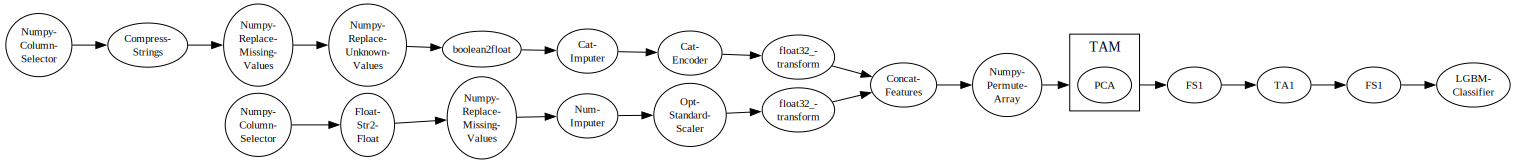

In [25]:
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.

### Pipeline source code

In [ ]:
best_pipeline.pretty_print(ipython_display=True, astype='sklearn')

In the pretty-printed code, `>>` is the pipe combinator (dataflow
edge) and `&` is the and combinator (combining multiple subpipelines).
They correspond to the `make_pipeline` and `make_union` functions from
scikit-learn, respectively. If you prefer the functions, you can
instead pretty-print your pipeline with
`best_pipeline.pretty_print(ipython_display=True, combinators=False)`.

### Reading training data from COS

In [27]:
train_df = pipeline_optimizer.get_data_connections()[0].read()

train_X = train_df.drop(['Risk'], axis=1).values
train_y = train_df.Risk.values

### Test pipeline model locally

In [28]:
predicted_y = best_pipeline.predict(train_X)
predicted_y[:5]

array(['No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk'], dtype=object)

<a id="runs"></a>
## 5. Historical runs

In this section you learn to work with historical AutoPipelines fit jobs (runs).

To list historical runs use method `list()`.

**Note**: You can filter runs by providing experiment name.

In [ ]:
experiment.runs(filter='Credit Risk Prediction - AutoAI').list()

To work with historical pipelines found during a particular optimizer
run, you need to first provide the `run_id` to select the fitted
optimizer.

**Note:** you can assign selected run_id to the `run_id` variable.

In [30]:
run_id = run_details['metadata']['id']

### Get executed optimizer's configuration parameters

In [ ]:
experiment.runs.get_params(run_id=run_id)


### Get historical optimizer instance and training details

In [32]:
historical_opt = experiment.runs.get_optimizer(run_id)

In [33]:
run_details = historical_opt.get_run_details()

### List trained pipelines for selected optimizer

In [34]:
historical_opt.summary()

,Enhancements,Estimator,training_roc_auc_(optimized),holdout_average_precision,holdout_log_loss,training_accuracy,holdout_roc_auc,training_balanced_accuracy,training_f1,holdout_precision,training_average_precision,training_log_loss,holdout_recall,training_precision,holdout_accuracy,holdout_balanced_accuracy,training_recall,holdout_f1
Pipeline Name,,,,,,,,,,,,,,,,,,
Pipeline_7,"HPO, FE",LGBMClassifier,0.841758,0.483247,0.035322,0.812553,0.808824,0.773513,0.866249,1.000000,0.911601,0.530526,1.000000,0.862465,1.00,1.000000,0.871795,1.000000
Pipeline_8,"HPO, FE, HPO",LGBMClassifier,0.841758,0.483247,0.035322,0.812553,0.808824,0.773513,0.866249,1.000000,0.911601,0.530526,1.000000,0.862465,1.00,1.000000,0.871795,1.000000
Pipeline_2,HPO,RandomForestClassifier,0.857733,0.540481,0.526002,0.781261,0.772059,0.760147,0.838123,0.833333,0.933404,0.492098,0.882353,0.863971,0.80,0.753676,0.814103,0.857143
Pipeline_4,"HPO, FE, HPO",RandomForestClassifier,0.863282,0.539113,0.531957,0.785706,0.764706,0.766735,0.840249,0.857143,0.931310,0.458750,0.705882,0.869655,0.72,0.727941,0.814103,0.774194
Pipeline_1,,RandomForestClassifier,0.831319,0.541076,0.140314,0.776637,0.750000,0.718595,0.843970,0.944444,0.897284,0.859232,1.000000,0.824549,0.96,0.937500,0.865385,0.971429
Pipeline_3,"HPO, FE",RandomForestClassifier,0.857885,0.537330,0.518701,0.790150,0.750000,0.773981,0.842970,0.800000,0.927565,0.459822,0.705882,0.876053,0.68,0.665441,0.814103,0.750000
Pipeline_5,,LGBMClassifier,0.830369,0.483247,0.084911,0.763483,0.750000,0.742956,0.823782,1.000000,0.921218,0.546042,1.000000,0.855433,1.00,1.000000,0.794872,1.000000
Pipeline_6,HPO,LGBMClassifier,0.830369,0.483247,0.084911,0.763483,0.750000,0.742956,0.823782,1.000000,0.921218,0.546042,1.000000,0.855433,1.00,1.000000,0.794872,1.000000


### Get selected pipeline and test locally

In [35]:
hist_pipeline = historical_opt.get_pipeline(pipeline_name='Pipeline_3')

In [36]:
predicted_y = hist_pipeline.predict(train_X)
predicted_y[:5]

array(['No Risk', 'No Risk', 'No Risk', 'No Risk', 'Risk'], dtype=object)

---

<a id="refinery"></a>
## 6. Pipeline refinement with [Lale](https://github.com/IBM/lale) and testing

In this section you learn how to refine and retrain the best
pipeline returned by AutoAI. There are many ways to refine a pipeline.
For illustration, simply replace the final estimator in the
pipeline by an interpretable model. The call to
`wrap_imported_operators()` augments scikit-learn operators with
schemas for hyperparameter tuning.

In [37]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import Hyperopt
from lale import wrap_imported_operators

wrap_imported_operators()

### Pipeline decomposition and new definition

Start by removing the last step of the pipeline, i.e., the final estimator.

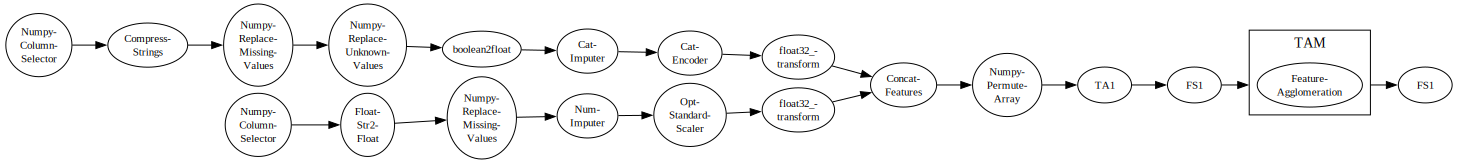

In [38]:
prefix = hist_pipeline.remove_last().freeze_trainable()
prefix.visualize()

Next, add a new final step, which consists of a choice of three
estimators. In this code, `|` is the or combinator (algorithmic
choice). It defines a search space for another optimizer run.

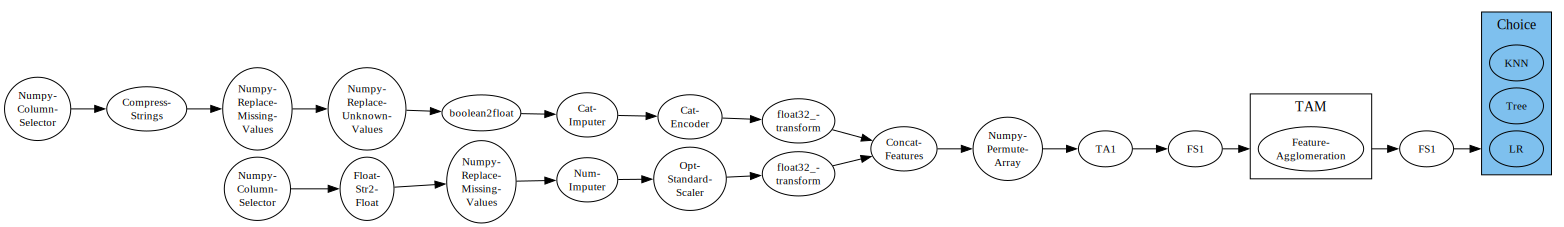

In [39]:
new_pipeline = prefix >> (LR | Tree | KNN)
new_pipeline.visualize()

### New optimizer `Hyperopt` configuration and training

To automatically select the algorithm and tune its hyperparameters, we
create an instance of the `Hyperopt` optimizer and `fit` it to the
data.

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.15, random_state=33)

In [41]:
hyperopt = Hyperopt(estimator=new_pipeline, cv=3, max_evals=20, scoring='roc_auc')
hyperopt_pipelines = hyperopt.fit(X_train, y_train)

The enumeration ['FeatureAgglomeration'] is all lale operators, but the schema fragment {'enum': [FeatureAgglomeration()]} it is part of does not stipulate that it should be 'laleType':'operator'.  While legal, this likely indicates either an omission in the schema or a bug in the schema simplifier
The enumeration ['FeatureAgglomeration'] is all lale operators, but the schema fragment {'enum': [FeatureAgglomeration()]} it is part of does not stipulate that it should be 'laleType':'operator'.  While legal, this likely indicates either an omission in the schema or a bug in the schema simplifier


100%|██████████| 20/20 [00:04<00:00,  4.33trial/s, best loss: -0.8014794685990339]


In [42]:
pipeline_model = hyperopt_pipelines.get_pipeline()

### Pipeline model tests and visualization

In [43]:
from sklearn.metrics import roc_auc_score

predicted_y = pipeline_model.predict(X_test)
score = roc_auc_score(predicted_y=='Risk', y_test=='Risk')
print(f'roc_auc_score {score:.1%}')

roc_auc_score 91.4%


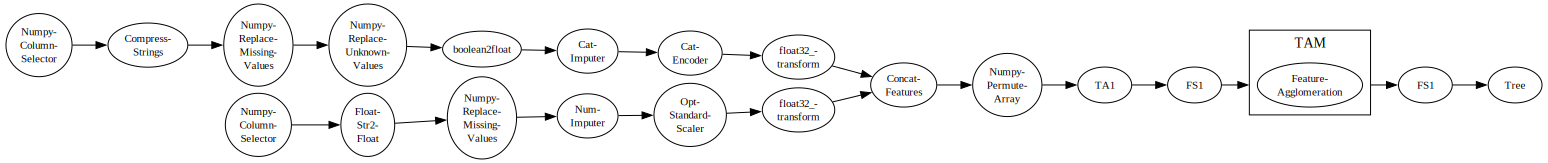

In [44]:
pipeline_model.visualize()

<a id="scoring"></a>
## 7. Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using watsonx.ai Runtime instance.

In [45]:
pipeline_name = "Pipeline_1"

### Online deployment creation

In [47]:
from ibm_watsonx_ai.deployment import WebService

service = WebService(credentials, source_space_id=space_id)

service.create(
    experiment_run_id=run_id,
    model=pipeline_name, 
    deployment_name="Credit Risk Deployment AutoAI")

Preparing an AutoAI Deployment...
Published model uid: f1fc9b46-5d3a-4d64-85d3-9ac360f1b316
Deploying model f1fc9b46-5d3a-4d64-85d3-9ac360f1b316 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: 'f1fc9b46-5d3a-4d64-85d3-9ac360f1b316' started

#######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.
..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='39b9b34c-412b-4eff-b554-3bfcdead9f4f'
------------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [ ]:
print(service)

To show all available information about the deployment use the `.get_params()` method:

In [ ]:
service.get_params()

### Scoring of webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [50]:
predictions = service.score(payload=train_df.drop(['Risk'], axis=1).iloc[:10])
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [1.0, 0.0]],
    ['No Risk', [1.0, 0.0]],
    ['No Risk', [1.0, 0.0]],
    ['No Risk', [1.0, 0.0]],
    ['Risk', [0.1, 0.9]],
    ['Risk', [0.0, 1.0]],
    ['No Risk', [1.0, 0.0]],
    ['No Risk', [1.0, 0.0]],
    ['No Risk', [0.9226527570789866, 0.07734724292101341]],
    ['Risk', [0.0, 1.0]]]}]}

If you want to work with the web service in an external Python application you can retrieve the service object by:
 - Initialize the service by `service = WebService(wml_credentials)`
 - Get deployment_id by `service.list()` method
 - Get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

### Deleting deployment
You can delete the existing deployment by calling the `service.delete()` command.
To list the existing web services you can use `service.list()`.

### Batch deployment creation

A batch deployment processes input data from a inline data and return predictions in scoring details.

In [51]:
batch_payload_df = train_df.drop(['Risk'], axis=1)[:5]
batch_payload_df

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,CurrentResidenceDuration,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,3,savings_insurance,32,none,own,1,skilled,1,none,yes
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,2,savings_insurance,37,stores,own,2,skilled,1,none,yes
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,3,real_estate,28,none,own,2,skilled,1,yes,no
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,2,savings_insurance,32,none,own,1,skilled,1,none,yes
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,3,unknown,57,none,own,2,skilled,1,none,yes


Create batch deployment for `Pipeline_2` created in AutoAI experiment with the `run_id`.

In [52]:
from ibm_watsonx_ai.deployment import Batch

service_batch = Batch(credentials,source_space_id=space_id)
service_batch.create(
            experiment_run_id=run_id,
            model="Pipeline_2",
            deployment_name="Credit Risk Batch Deployment AutoAI")

Preparing an AutoAI Deployment...
Published model uid: 228b423c-014d-4cd4-9be1-b22c551e721a
Deploying model 228b423c-014d-4cd4-9be1-b22c551e721a using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '228b423c-014d-4cd4-9be1-b22c551e721a' started

#######################################################################################


ready.


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='53639d07-413f-4060-aa01-5c59d7e5ac32'
------------------------------------------------------------------------------------------------




### Score batch deployment with inline payload as pandas DataFrame.

In [53]:
scoring_params = service_batch.run_job(
            payload=batch_payload_df,
            background_mode=False)



##########################################################################

Synchronous scoring for id: '04e1d400-ffb5-4375-9f50-d50f46a48d33' started

##########################################################################


queued.
completed
Scoring job  '04e1d400-ffb5-4375-9f50-d50f46a48d33' finished successfully.


In [54]:
scoring_params['entity']['scoring'].get('predictions')

[{'fields': ['prediction', 'probability'],
  'values': [['No Risk', [0.681817595866456, 0.31818240413354404]],
   ['No Risk', [0.719170235787862, 0.28082976421213796]],
   ['No Risk', [0.6499023905644395, 0.35009760943556023]],
   ['No Risk', [0.6670315450219109, 0.3329684549780888]],
   ['Risk', [0.3391099066585166, 0.6608900933414837]]]}]

<a id="cleanup"></a>
## 8. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
## 9. Summary and next steps

 You successfully completed this notebook!
 
 You learned how to use `ibm-watsonx-ai` to run AutoAI experiments. 
 
 Check out our _[Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

**Amadeusz Masny**, Python Software Developer at watsonx.ai

**Kiran Kate**, Senior Software Engineer at IBM Research AI

**Martin Hirzel**, Research Staff Member and Manager at IBM Research AI

**Mateusz Szewczyk**, Software Engineer at watsonx.ai

Copyright © 2020-2025 IBM. This notebook and its source code are released under the terms of the MIT License.